# Entanglement Structure and Circuit Depth
## Why Some States Need Deeper Circuits

A key insight in quantum compilation is that the **entanglement structure** of a state determines how deep a quantum circuit must be to prepare it. States with more entanglement require more two-qubit gates, and therefore deeper circuits.

In this notebook you will:
1. Compute von Neumann entanglement entropy profiles across different states
2. Study how circuit fidelity improves with increasing depth
3. See that entropy predicts the number of layers required
4. Compare two circuit topologies: **staircase** and **brickwork**

## Von Neumann Entanglement Entropy

For an $N$-qubit state $|\psi\rangle$, we can partition the system into sites $1, \ldots, k$ (subsystem $A$) and $k+1, \ldots, N$ (subsystem $B$). The **reduced density matrix** is $\rho_A = \mathrm{Tr}_B |\psi\rangle\langle\psi|$ and the **von Neumann entropy** is:

$$S(k) = -\mathrm{Tr}(\rho_A \log \rho_A) = -\sum_i p_i \log p_i$$

where $p_i$ are the squared Schmidt values at bipartition $k$.

**Key facts:**
- Product states: $S = 0$ at every bipartition
- GHZ state: $S = \log 2 \approx 0.693$ everywhere (uniform entanglement)
- Random MPS with bond dimension $\chi$: $S \leq \log \chi$
- Higher entropy means more entanglement, which means a deeper circuit is needed

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.MPS
using TenSynth.MPS: wMPS, bond_dimensions, entanglement_entropy

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


TenSynth loaded successfully.


## 1. Entanglement Entropy Profiles

Let's compute the entropy at every bipartition for several different 8-qubit states and see how they compare.

In [2]:
N = 8
Random.seed!(42)

states = [
    ("GHZ",       ghzMPS(N)),
    ("W",         wMPS(N)),
    ("Random χ=2", randMPS(N, 2)),
    ("Random χ=4", randMPS(N, 4)),
    ("Random χ=8", randMPS(N, 8)),
]

# Compute entropy at each bipartition site k = 1, ..., N-1
sites = 1:(N-1)
entropy_data = Dict{String, Vector{Float64}}()

for (label, mps) in states
    S = [entanglement_entropy(mps, k) for k in sites]
    entropy_data[label] = S
    println("$label:  max S = $(round(maximum(S), digits=4)),  ",
            "bond dims = $(bond_dimensions(mps))")
end

GHZ:  max S = 0.6931,  bond dims = [2, 2, 2, 2, 2, 2, 2]
W:  max S = 0.6931,  bond dims = [2, 2, 2, 2, 2, 2, 2]
Random χ=2:  max S = 0.4182,  bond dims = [2, 2, 2, 2, 2, 2, 2]
Random χ=4:  max S = 1.1071,  bond dims = [4, 4, 4, 4, 4, 4, 2]
Random χ=8:  max S = 1.7035,  bond dims = [8, 8, 8, 8, 8, 4, 2]


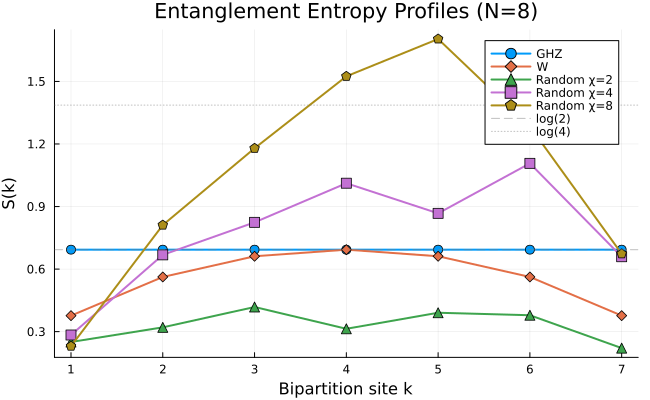

In [3]:
p = plot(title="Entanglement Entropy Profiles (N=$N)",
         xlabel="Bipartition site k", ylabel="S(k)",
         legend=:topright, size=(650, 400))

markers = [:circle, :diamond, :utriangle, :square, :pentagon]
for (i, (label, _)) in enumerate(states)
    plot!(p, collect(sites), entropy_data[label],
          label=label, marker=markers[i], linewidth=2, markersize=5)
end

# Reference lines for log(chi) bounds
hline!(p, [log(2)], linestyle=:dash, color=:gray, alpha=0.5, label="log(2)")
hline!(p, [log(4)], linestyle=:dot, color=:gray, alpha=0.5, label="log(4)")

p

**Observations:**
- The GHZ state has **flat** entropy $S = \log 2$ at every cut — uniform entanglement
- The W state peaks in the bulk and drops at the edges
- Random MPS entropy increases with bond dimension $\chi$, bounded by $\log \chi$
- The entropy profile is **not** uniform for random states — it peaks in the middle of the chain

## 2. Circuit Depth Scaling

Now the central question: **how many circuit layers do we need to achieve a given fidelity?**

We'll decompose states with increasing entanglement at different circuit depths using the iterative method and track the achieved fidelity.

In [4]:
Random.seed!(42)
N = 6  # Use 6 qubits for faster computation

test_states = [
    ("W",         wMPS(N)),
    ("Random χ=2", randMPS(N, 2)),
    ("Random χ=4", randMPS(N, 4)),
    ("Random χ=8", randMPS(N, 8)),
]

depths = 1:8
fidelity_vs_depth = Dict{String, Vector{Float64}}()

for (label, mps) in test_states
    fids = Float64[]
    for d in depths
        result = decompose(mps;
            method=:iterative,
            max_layers=d,
            n_sweeps=50,
            target_fidelity=1.0,  # push to get the best at this depth
            verbose=false
        )
        push!(fids, result.fidelity)
    end
    fidelity_vs_depth[label] = fids
    println("$label:  fidelity at depth 1=$(round(fids[1], digits=4)), ",
            "depth 4=$(round(fids[4], digits=4)), ",
            "depth 8=$(round(fids[end], digits=4))")
end

W:  fidelity at depth 1=0.3333, depth 4=1.0, depth 8=1.0
Random χ=2:  fidelity at depth 1=0.7181, depth 4=1.0, depth 8=1.0
Random χ=4:  fidelity at depth 1=0.5025, depth 4=0.9759, depth 8=1.0
Random χ=8:  fidelity at depth 1=0.3286, depth 4=0.9386, depth 8=1.0


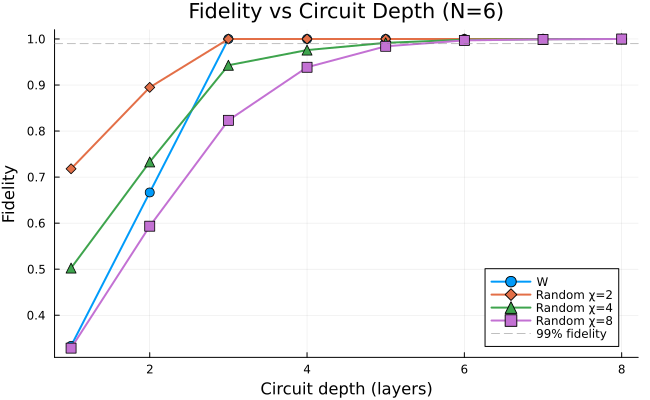

In [5]:
p = plot(title="Fidelity vs Circuit Depth (N=$N)",
         xlabel="Circuit depth (layers)", ylabel="Fidelity",
         legend=:bottomright, size=(650, 400))

markers = [:circle, :diamond, :utriangle, :square]
for (i, (label, _)) in enumerate(test_states)
    plot!(p, collect(depths), fidelity_vs_depth[label],
          label=label, marker=markers[i], linewidth=2, markersize=5)
end

hline!(p, [0.99], linestyle=:dash, color=:gray, alpha=0.5, label="99% fidelity")

p

**Key observations:**
- **W** ($\chi=2$) and **Random $\chi=2$** converge quickly at shallow depths — low bond dimension means low entanglement
- **Random $\chi=4$** needs more layers to reach high fidelity
- **Random $\chi=8$** requires the most layers — higher entanglement demands deeper circuits
- The depth required correlates with the bond dimension (and hence maximum entanglement entropy) of the state

## 3. Entropy Predicts Compilability

Let's make this relationship precise. For each state, we find the minimum depth needed to reach 99% fidelity and plot it against the maximum entanglement entropy.

In [6]:
# Find minimum depth to reach 99% fidelity for each state
threshold = 0.99

scatter_data = []
for (label, mps) in test_states
    # Max entropy across all bipartitions
    max_S = maximum(entanglement_entropy(mps, k) for k in 1:(length(mps.tensors)-1))
    
    # Min depth to reach threshold
    fids = fidelity_vs_depth[label]
    depth_needed = findfirst(f -> f >= threshold, fids)
    if depth_needed === nothing
        depth_needed = length(fids)  # didn't reach threshold
    end
    
    push!(scatter_data, (label=label, max_entropy=max_S, depth=depth_needed))
    println("$label:  max S = $(round(max_S, digits=4)),  ",
            "layers to $(Int(threshold*100))% = $depth_needed")
end

W:  max S = 0.6931,  layers to 99% = 3
Random χ=2:  max S = 0.5372,  layers to 99% = 3
Random χ=4:  max S = 0.9756,  layers to 99% = 5
Random χ=8:  max S = 1.427,  layers to 99% = 6


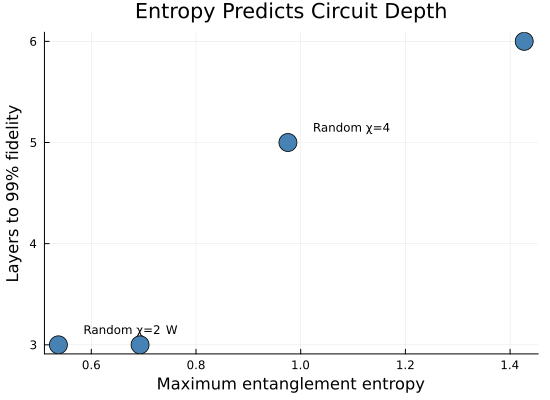

In [7]:
max_entropies = [d.max_entropy for d in scatter_data]
depths_needed = [d.depth for d in scatter_data]
labels = [d.label for d in scatter_data]

p = scatter(max_entropies, depths_needed,
    xlabel="Maximum entanglement entropy",
    ylabel="Layers to 99% fidelity",
    title="Entropy Predicts Circuit Depth",
    markersize=10, legend=false,
    size=(550, 400), color=:steelblue)

# Annotate each point
for d in scatter_data
    annotate!(p, d.max_entropy + 0.05, d.depth + 0.15, 
              text(d.label, 8, :left))
end

p

States with higher maximum entanglement entropy consistently require more circuit layers. This is a fundamental relationship: **entanglement is the resource that two-qubit gates must build up**, and more entanglement requires more gates.

## 4. Circuit Topologies

TenSynth supports different circuit **topologies** that determine how two-qubit gates are arranged:

### Staircase
Gates are applied sequentially across the chain. Each layer contains gates on *all* neighbouring pairs:
```
Layer: (1,2), (2,3), (3,4), (4,5), ...
```
Gates in a layer **overlap** (share qubits), so they cannot be executed in parallel on hardware.

### Brickwork
Gates alternate between even and odd pairs:
```
Odd layer:  (1,2), (3,4), (5,6), ...
Even layer: (2,3), (4,5), (6,7), ...
```
Gates within each layer are **non-overlapping**, making brickwork naturally hardware-friendly.

In [8]:
N_demo = 6

println("=== STAIRCASE topology (N=$N_demo, 3 layers) ===")
staircase_inds = generate_circuit_indices(N_demo, STAIRCASE, 3)
for (i, layer) in enumerate(staircase_inds)
    println("  Layer $i: $layer")
end

println()
println("=== BRICKWORK topology (N=$N_demo, 4 layers) ===")
brickwork_inds = generate_circuit_indices(N_demo, BRICKWORK, 4)
for (i, layer) in enumerate(brickwork_inds)
    non_overlap = is_non_overlapping_layer(layer)
    println("  Layer $i: $layer  (non-overlapping: $non_overlap)")
end

=== STAIRCASE topology (N=6, 3 layers) ===
  Layer 1: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Layer 2: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
  Layer 3: [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

=== BRICKWORK topology (N=6, 4 layers) ===
  Layer 1: [(1, 2), (3, 4), (5, 6)]  (non-overlapping: true)
  Layer 2: [(2, 3), (4, 5)]  (non-overlapping: true)
  Layer 3: [(1, 2), (3, 4), (5, 6)]  (non-overlapping: true)
  Layer 4: [(2, 3), (4, 5)]  (non-overlapping: true)


## 5. Topology Comparison

Does the topology affect how efficiently we can compile a state? Let's compare staircase and brickwork on the same random MPS.

In [9]:
Random.seed!(123)
N = 6
mps_target = randMPS(N, 4)

depths = 1:8
topo_results = Dict{Symbol, Vector{Float64}}()

for topo in [:staircase, :brickwork]
    fids = Float64[]
    for d in depths
        result = decompose(mps_target;
            method=:iterative,
            max_layers=d,
            n_sweeps=50,
            target_fidelity=1.0,
            topology=topo,
            verbose=false
        )
        push!(fids, result.fidelity)
    end
    topo_results[topo] = fids
    println("$topo:  depth 2=$(round(fids[2], digits=4)), ",
            "depth 4=$(round(fids[4], digits=4)), ",
            "depth 8=$(round(fids[end], digits=4))")
end

staircase:  depth 2=0.9787, depth 4=0.9998, depth 8=1.0
brickwork:  depth 2=0.7671, depth 4=0.9822, depth 8=1.0


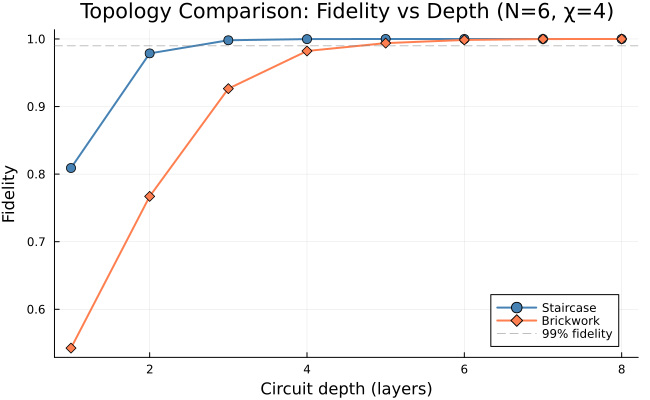

In [10]:
p = plot(title="Topology Comparison: Fidelity vs Depth (N=$N, χ=4)",
         xlabel="Circuit depth (layers)", ylabel="Fidelity",
         legend=:bottomright, size=(650, 400))

plot!(p, collect(depths), topo_results[:staircase],
      label="Staircase", marker=:circle, linewidth=2, markersize=5, color=:steelblue)
plot!(p, collect(depths), topo_results[:brickwork],
      label="Brickwork", marker=:diamond, linewidth=2, markersize=5, color=:coral)

hline!(p, [0.99], linestyle=:dash, color=:gray, alpha=0.5, label="99% fidelity")

p

**Staircase** layers contain more gates (all $N-1$ pairs), so they reach high fidelity at shallower nominal depth. **Brickwork** layers have fewer gates each but are hardware-friendly. The choice is a trade-off between total gate count and parallelism.

In [11]:
# Gate count comparison
for topo in [:staircase, :brickwork]
    inds = generate_circuit_indices(N, topology_from_symbol(topo), 4)
    total_gates = sum(length(layer) for layer in inds)
    println("$topo (4 layers):  $total_gates total gates, ",
            "gates/layer = $(length.(inds))")
end

staircase (4 layers):  20 total gates, gates/layer = [5, 5, 5, 5]
brickwork (4 layers):  10 total gates, gates/layer = [3, 2, 3, 2]


## 6. Analytical vs Iterative at Different Entanglement Levels

The **analytical** method (SVD-based) is exact for low bond dimension but degrades for highly entangled states. Let's see how the methods compare as we increase $\chi$.

In [12]:
Random.seed!(42)
N = 6
chi_values = [2, 3, 4, 6, 8]
method_comparison = Dict{Symbol, Vector{Float64}}()

for m in [:analytical, :iterative]
    fids = Float64[]
    for chi in chi_values
        Random.seed!(42)
        mps = randMPS(N, chi)
        result = decompose(mps;
            method=m,
            max_layers=6,
            n_sweeps=50,
            target_fidelity=1.0,
            verbose=false
        )
        push!(fids, result.fidelity)
    end
    method_comparison[m] = fids
end

for m in [:analytical, :iterative]
    println("$m:  ", join(["χ=$c → $(round(f, digits=4))" 
                           for (c, f) in zip(chi_values, method_comparison[m])], ",  "))
end

analytical:  χ=2 → 0.9985,  χ=3 → 0.9974,  χ=4 → 0.9833,  χ=6 → 0.9766,  χ=8 → 0.9799
iterative:  χ=2 → 1.0,  χ=3 → 0.9999,  χ=4 → 0.9985,  χ=6 → 0.9965,  χ=8 → 0.9991


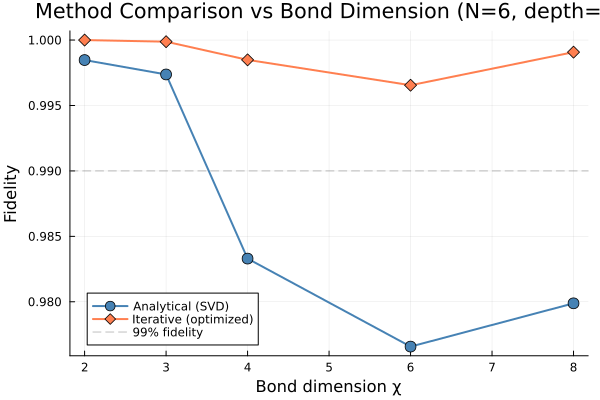

In [13]:
p = plot(title="Method Comparison vs Bond Dimension (N=$N, depth=6)",
         xlabel="Bond dimension χ", ylabel="Fidelity",
         legend=:bottomleft, size=(600, 400))

plot!(p, chi_values, method_comparison[:analytical],
      label="Analytical (SVD)", marker=:circle, linewidth=2, 
      markersize=6, color=:steelblue)
plot!(p, chi_values, method_comparison[:iterative],
      label="Iterative (optimized)", marker=:diamond, linewidth=2,
      markersize=6, color=:coral)

hline!(p, [0.99], linestyle=:dash, color=:gray, alpha=0.5, label="99% fidelity")

p

The **iterative** method maintains high fidelity even as bond dimension grows, because it variationally optimizes each layer. The **analytical** method degrades because its SVD-based decomposition produces circuits whose depth is set by the MPS structure, not the target fidelity.

## Summary

In this notebook you learned:

- **Entanglement entropy** $S(k)$ quantifies entanglement across a bipartition
- States with higher $S$ require **deeper circuits** for faithful preparation
- Maximum entropy **predicts** the minimum circuit depth needed
- **Staircase** topology has more gates per layer (fewer layers needed), while **brickwork** is hardware-friendly
- The **iterative** method is more robust to high entanglement than the **analytical** method

**Key functions used:**
- `entanglement_entropy(mps, site)` — von Neumann entropy at a bipartition
- `decompose(mps; method, max_layers, topology, ...)` — decompose MPS into circuit
- `generate_circuit_indices(N, topology, n_layers)` — generate gate layout
- `topology_from_symbol(:brickwork)` — convert symbol to topology enum
- `STAIRCASE`, `BRICKWORK` — topology constants
- `is_non_overlapping_layer(layer)` — check if gates can run in parallel

**Next**: Notebook 03 applies these ideas to physics-relevant ground states from DMRG.